# 케라스

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 파이썬에서 작업의 진행을 볼 수 있도록 하는 라이브러리
import warnings
warnings.filterwarnings(action='ignore')

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

np.random.seed(10)

random_dim = 100

In [ ]:
def load_mnist_data():
    # mnist 데이터 불러오기
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # 데이터를 -1~1 사이로 normalize
    x_train = (x_train.astype(np.float32)-127.5)/127.5
    
    # (60000,28,28) -> (60000,784)
    x_train = x_train.reshape(60000,784)  
    return (x_train, y_train, x_test, y_test)

In [ ]:
# Optimizer 설정
def get_optimizer():
    return Adam(lr=0.002, beta_1=0.5)

# Generator 설정
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, 
                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    # 784차원의 이미지를 생성해야 하므로 784
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 설정
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784,
                           kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    # 가짜인지 진짜인지를 구별하므로 이중 분류를 위해 1
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator    

In [ ]:
# GAN 모델 구성
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # Generator와 Discriminator를 동시에 학습시키고 싶을 때 discriminator의 trainable을 False로 설정
    discriminator.trainable = False
    
    # GAN 입력(노이즈)은 위에서 100차원으로 설정함
    gan_input = Input(shape=(random_dim,))
    
    # Generator의 결과는 784차원의 이미지
    x = generator(gan_input)
    
    # Discriminator의 결과는 Generator의 결과 이미지가 진짜인지 가짜인지에 대한 확률
    gan_output = discriminator(x)
    
    # 결국 GAN 모델은 generator의 생성물이 input으로 들어가고,
    # 그 input이 진짜인지 가짜인지 discriminator가 loss 함수를 이용해 판별
    # 이 loss 함수값을 줄이도록 모델이 작동할 것이므로, generator는 점점 진짜같은 이미지를 만들게 됨
    # 그리고 loss 함수값이 줄어든다는 것은 곧 discriminator의 구분 실력이 50%에 가까워진다는 것
    
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [ ]:
# 생성된 MNIST를 보여주는 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
# 네트워크 훈련 및 생성된 이미지 시각화
def train(epochs=1, batch_size=128):

    x_train, y_train, x_test, y_test = load_mnist_data()
    
    batch_count = x_train.shape[0] // batch_size
    
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # 입력으로 사용할 랜덤 노이즈와 이미지를 가져오기
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)]
            
            # MNIST 이미지 생성
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
            
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            # Discriminator 학습
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            # Generator 학습
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:45<00:00,  4.45it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.31it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.32it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.32it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.35it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.30it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.26it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.26it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:44<00:00,  4.50it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.30it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.23it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.29it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.40it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.37it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.39it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.37it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.36it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.35it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:50<00:00,  4.25it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:38<00:00,  4.73it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.95it/s]


--------------- Epoch 41 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 42 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.29it/s]


--------------- Epoch 43 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.34it/s]


--------------- Epoch 44 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 45 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [02:09<00:00,  3.61it/s]


--------------- Epoch 46 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:43<00:00,  4.53it/s]


--------------- Epoch 47 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:40<00:00,  4.65it/s]


--------------- Epoch 48 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:47<00:00,  4.36it/s]


--------------- Epoch 49 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:57<00:00,  3.99it/s]


--------------- Epoch 50 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:37<00:00,  4.78it/s]


--------------- Epoch 51 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [02:17<00:00,  3.39it/s]


--------------- Epoch 52 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [02:23<00:00,  3.27it/s]


--------------- Epoch 53 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:39<00:00,  4.71it/s]


--------------- Epoch 54 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:38<00:00,  4.75it/s]


--------------- Epoch 55 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.26it/s]


--------------- Epoch 56 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:55<00:00,  4.04it/s]


--------------- Epoch 57 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:50<00:00,  4.24it/s]


--------------- Epoch 58 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 59 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.37it/s]


--------------- Epoch 60 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.92it/s]


--------------- Epoch 61 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:37<00:00,  4.79it/s]


--------------- Epoch 62 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:40<00:00,  4.66it/s]


--------------- Epoch 63 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.30it/s]


--------------- Epoch 64 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 65 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:43<00:00,  4.51it/s]


--------------- Epoch 66 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [02:25<00:00,  3.21it/s]


--------------- Epoch 67 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.95it/s]


--------------- Epoch 68 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.90it/s]


--------------- Epoch 69 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 70 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:40<00:00,  4.67it/s]


--------------- Epoch 71 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:36<00:00,  4.87it/s]


--------------- Epoch 72 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:41<00:00,  4.63it/s]


--------------- Epoch 73 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 74 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 75 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.96it/s]


--------------- Epoch 76 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:38<00:00,  4.76it/s]


--------------- Epoch 77 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 78 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.39it/s]


--------------- Epoch 79 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.48it/s]


--------------- Epoch 80 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:39<00:00,  4.69it/s]


--------------- Epoch 81 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.92it/s]


--------------- Epoch 82 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.14it/s]


--------------- Epoch 83 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.41it/s]


--------------- Epoch 84 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.92it/s]


--------------- Epoch 85 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.89it/s]


--------------- Epoch 86 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 87 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 88 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.92it/s]


--------------- Epoch 89 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:43<00:00,  4.52it/s]


--------------- Epoch 90 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.91it/s]


--------------- Epoch 91 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.56it/s]


--------------- Epoch 92 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.90it/s]


--------------- Epoch 93 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 94 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:35<00:00,  4.90it/s]


--------------- Epoch 95 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.41it/s]


--------------- Epoch 96 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:32<00:00,  5.09it/s]


--------------- Epoch 97 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 98 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:46<00:00,  4.38it/s]


--------------- Epoch 99 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 100 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 101 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 102 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 103 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.38it/s]


--------------- Epoch 104 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 105 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 106 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.97it/s]


--------------- Epoch 107 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 108 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.55it/s]


--------------- Epoch 109 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 110 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.56it/s]


--------------- Epoch 111 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:36<00:00,  4.84it/s]


--------------- Epoch 112 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 113 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 114 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:28<00:00,  5.30it/s]


--------------- Epoch 115 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 116 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:48<00:00,  4.30it/s]


--------------- Epoch 117 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:36<00:00,  4.85it/s]


--------------- Epoch 118 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [02:02<00:00,  3.83it/s]


--------------- Epoch 119 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 120 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:29<00:00,  5.24it/s]


--------------- Epoch 121 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 122 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 123 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.94it/s]


--------------- Epoch 124 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 125 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 126 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:34<00:00,  4.94it/s]


--------------- Epoch 127 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 128 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 129 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 130 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.69it/s]


--------------- Epoch 131 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.36it/s]


--------------- Epoch 132 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 133 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.70it/s]


--------------- Epoch 134 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 135 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 136 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.70it/s]


--------------- Epoch 137 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.67it/s]


--------------- Epoch 138 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.69it/s]


--------------- Epoch 139 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 140 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.70it/s]


--------------- Epoch 141 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 142 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 143 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 144 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 145 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 146 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 147 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.63it/s]


--------------- Epoch 148 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 149 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 150 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.56it/s]


--------------- Epoch 151 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.64it/s]


--------------- Epoch 152 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 153 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.44it/s]


--------------- Epoch 154 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 155 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.42it/s]


--------------- Epoch 156 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.54it/s]


--------------- Epoch 157 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 158 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 159 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 160 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 161 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 162 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.52it/s]


--------------- Epoch 163 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 164 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 165 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 166 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 167 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.64it/s]


--------------- Epoch 168 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 169 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.46it/s]


--------------- Epoch 170 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.54it/s]


--------------- Epoch 171 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 172 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 173 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 174 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.69it/s]


--------------- Epoch 175 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.67it/s]


--------------- Epoch 176 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 177 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 178 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.71it/s]


--------------- Epoch 179 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.66it/s]


--------------- Epoch 180 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 181 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 182 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00,  5.37it/s]


--------------- Epoch 183 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.64it/s]


--------------- Epoch 184 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 185 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.67it/s]


--------------- Epoch 186 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 187 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 188 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.67it/s]


--------------- Epoch 189 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 190 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 191 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 192 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 193 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.50it/s]


--------------- Epoch 194 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.53it/s]


--------------- Epoch 195 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 196 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.64it/s]


--------------- Epoch 197 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 198 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.68it/s]


--------------- Epoch 199 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 200 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 201 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 202 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 203 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 204 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 205 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 206 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 207 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 208 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 209 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 210 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 211 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 212 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 213 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 214 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 215 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 216 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.63it/s]


--------------- Epoch 217 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.57it/s]


--------------- Epoch 218 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.64it/s]


--------------- Epoch 219 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 220 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 221 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 222 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 223 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 224 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 225 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.44it/s]


--------------- Epoch 226 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 227 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 228 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.54it/s]


--------------- Epoch 229 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.51it/s]


--------------- Epoch 230 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 231 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 232 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 233 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 234 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.61it/s]


--------------- Epoch 235 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.62it/s]


--------------- Epoch 236 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.50it/s]


--------------- Epoch 237 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.59it/s]


--------------- Epoch 238 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.58it/s]


--------------- Epoch 239 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:26<00:00,  5.40it/s]


--------------- Epoch 240 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:25<00:00,  5.45it/s]


--------------- Epoch 241 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.60it/s]


--------------- Epoch 242 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:22<00:00,  5.65it/s]


--------------- Epoch 243 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:24<00:00,  5.54it/s]


--------------- Epoch 244 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.57it/s]


--------------- Epoch 245 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:53<00:00,  4.11it/s]


--------------- Epoch 246 ---------------


 54%|██████████████████████████████████████████▉                                     | 251/468 [00:59<00:45,  4.74it/s]

KeyboardInterrupt: 

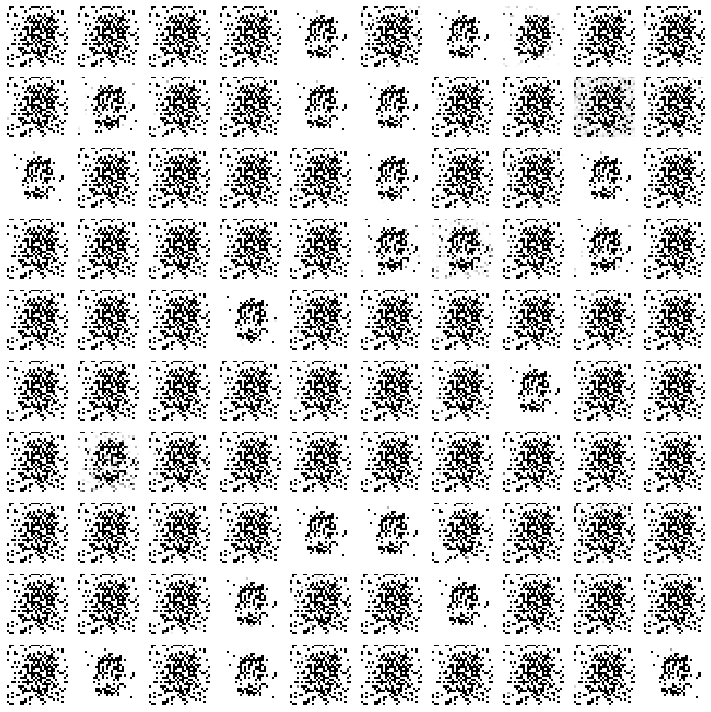

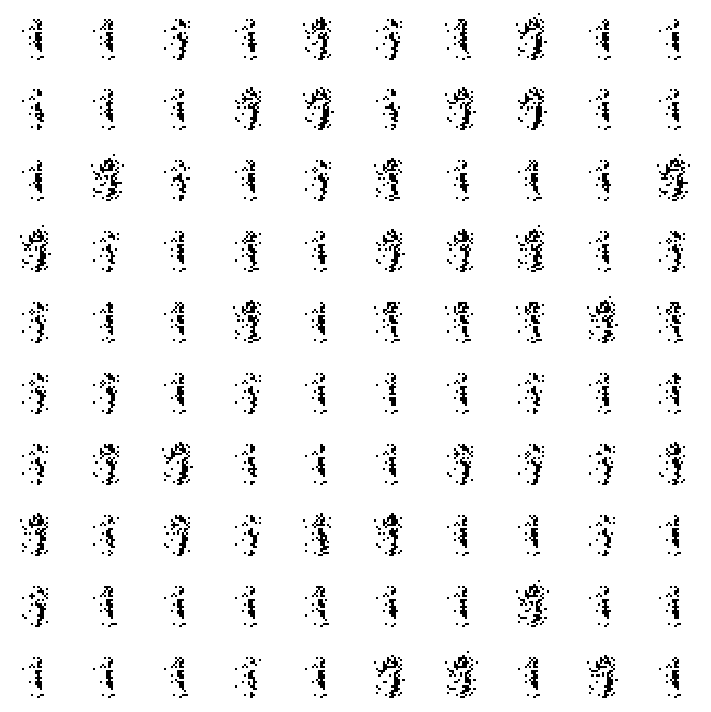

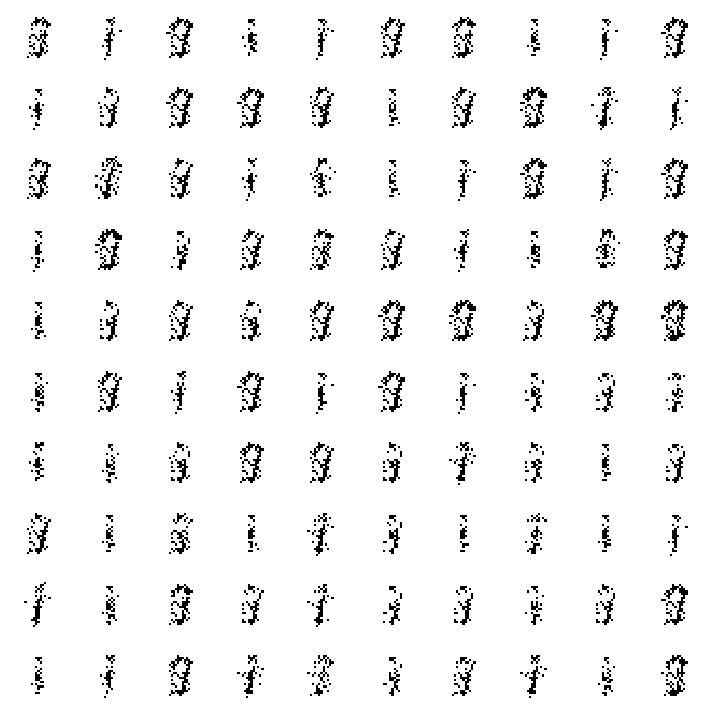

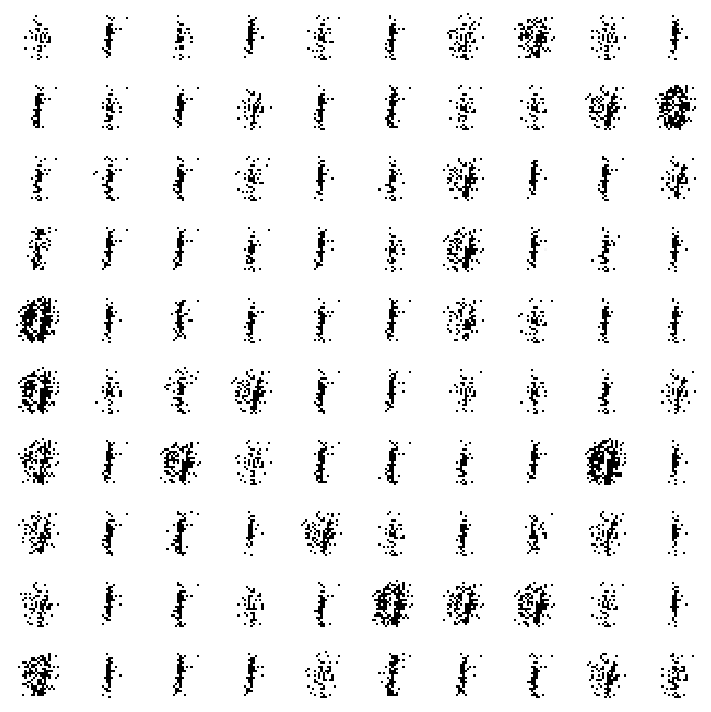

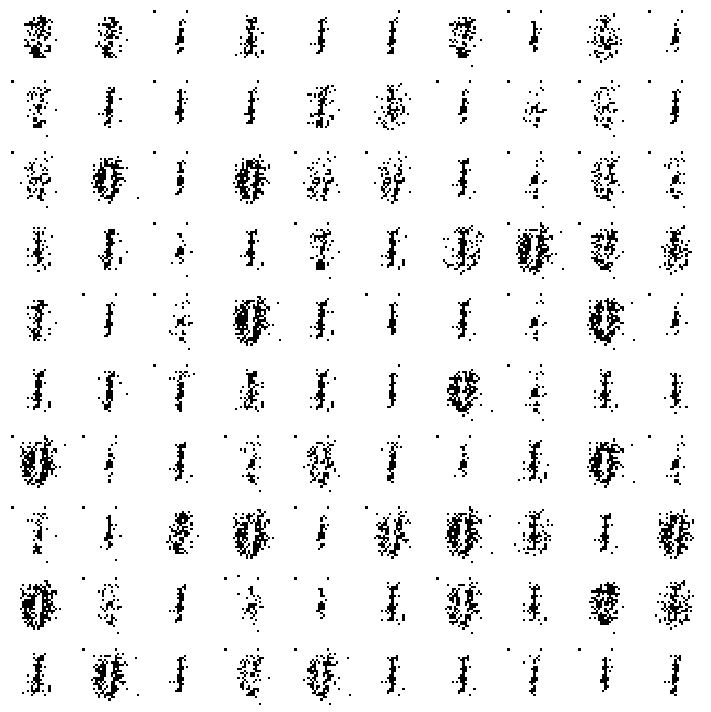

Error in callback <function flush_figures at 0x00000208FBF9F288> (for post_execute):


KeyboardInterrupt: 

In [ ]:
if __name__ == '__main__':
    train(400, 128)

# 파이토치

In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
# 생성자(Generator) 클래스 정의

latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # 하나의 블록 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # normalize를 한다고 하면 배치 정규화 수행 (차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),# 이 블록은 배치 정규화 적용 안되는 것
            *block(128, 256), # *표시는 이 함수가 변수를 더 받을 수도 있다는 뜻
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )
        
    def forward(self, z): # 모델에 넣은 z의 최종 결괏값이 이미지의 형태를 가질 수 있도록 하는 함수
        img = self.model(z) # 생성자 모델에 랜덤 노이즈 벡터 z가 들어갈 것
        img = img.view(img.size(0), 1, 28, 28) # img.size(0) = 배치 사이즈
        return img

In [3]:
# 판별자(Discriminator) 클래스 정의

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1*28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # 진짜 or 가짜, 즉 이진 분류를 위해 sigmoid 사용, 진짜일 확률값이 나오도록 한다
        )
        
    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1) # flatten을 통해 하나의 벡터로 쭉 나열한다
        output = self.model(flattened)
        return output

In [4]:
# 학습 데이터셋 불러오기

# 전처리 메소드
transforms_train = transforms.Compose([
    transforms.Resize(28), # 크기가 28*28이므로 맞춰준다
    transforms.ToTensor(), # 파이토치에서 텐서로써 쓸 수 있도록 해준다
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [6]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
# 모델 학습 및 샘플링

import time

n_epochs = 200 # 학습 횟수
sample_interval = 2000 # 몇 번의 배치마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
      
      # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
      real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜 = 1
      fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜 = 0
        
      real_imgs = imgs.cuda()
        
      """ 생성자 학습 """
        
      optimizer_G.zero_grad()
        
      # 랜덤 노이즈 샘플링
      z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
       
      # 이미지 생성
      generated_imgs = generator(z)
        
      # 생성자의 손실값 계산
      g_loss = adversarial_loss(discriminator(generated_imgs), real)
        
      # 생성자 업데이트
      g_loss.backward()
      optimizer_G.step()
        
      """ 판별자 학습 """
      optimizer_D.zero_grad()
        
      # 판별자의 손실값 계산
      real_loss = adversarial_loss(discriminator(real_imgs), real)
      fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        
      d_loss = (real_loss + fake_loss) / 2
        
      # 판별자 업데이트
      d_loss.backward()
      optimizer_D.step()
        
      done = epoch * len(dataloader) + i
      if done % sample_interval == 0:
          # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
          save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.253044] [G loss: 1.745247] [Elapsed time: 10.91s]
[Epoch 1/200] [D loss: 0.359538] [G loss: 2.023622] [Elapsed time: 21.76s]
[Epoch 2/200] [D loss: 0.399190] [G loss: 0.897272] [Elapsed time: 32.73s]
[Epoch 3/200] [D loss: 0.314564] [G loss: 1.067672] [Elapsed time: 43.62s]
[Epoch 4/200] [D loss: 0.356641] [G loss: 2.921574] [Elapsed time: 54.56s]
[Epoch 5/200] [D loss: 0.216529] [G loss: 1.422461] [Elapsed time: 65.55s]
[Epoch 6/200] [D loss: 0.227298] [G loss: 2.070296] [Elapsed time: 76.25s]
[Epoch 7/200] [D loss: 0.184270] [G loss: 1.631624] [Elapsed time: 87.05s]
[Epoch 8/200] [D loss: 0.151760] [G loss: 1.779156] [Elapsed time: 97.94s]
[Epoch 9/200] [D loss: 0.249030] [G loss: 1.647962] [Elapsed time: 108.68s]
[Epoch 10/200] [D loss: 0.157628] [G loss: 2.640949] [Elapsed time: 119.26s]
[Epoch 11/200] [D loss: 0.205427] [G loss: 2.322240] [Elapsed time: 130.11s]
[Epoch 12/200] [D loss: 0.176938] [G loss: 2.032139] [Elapsed time: 140.82s]
[Epoch 13/200] [D 

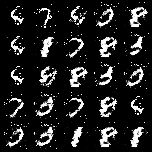

In [15]:
# 이미지 예시 출력

from IPython.display import Image

Image('92000.png')